# Diffusion of N particles in a box

<b> Goal</b>: Investigate N particle diffusing in (i) a <b>Closed Box</b> (ii) in an <b>Infinite Pool</b>. How do they fill the space? What is the number density profile both out and in equilibrium?

<b> ATTENTION<b>: This notebook contain pieces to simulate (i) and (ii). Pay attention at what part of code you de-comment on the "for cycle" and on the initialization steps of the simulation. 

<b> ATTENTION2<b>: This notebook uses external figures. 


In particular:

(i) <b>Closed Box</b> uses periodic boundary condition (<i>p_boundary</i>) and particles are created ONLY before starting the simulation (<i>create_in_point</i>), i.e. they never disappear from the box

(ii) <b>Infinite Pool</b> NEED to create N particles on the border of the Box (<i>create</i>) at the beginning and then each simulation step need to delete particles diffusing out (<i>check</i>) and create new ones (<i>create</i>)

In [123]:
# reset all variables
%reset -f
%reload_ext autoreload 
#force reload of file diffusionlab.py feel free to modify it if you need!
%autoreload 2


#load libraries
import numpy as np
import matplotlib.pyplot as plt

#external library. you have to SHUTDOWN AND RESTART THE KERNELS TO REFRESH IT IF YOU CHANGE IT
#it contains functions to plot the simulation and refresh the graphs
import libplot_diff as dl

#plot the figures in an external window
%matplotlib


Using matplotlib backend: QtAgg


N.B. This file uses an external libplot_diff.py library to store lengthy and not useful routines to plot and change plots during the simulation
Change it if you want.


The next three cells are for 

    (i) Declaring functions to manipulate particles
    (ii) Initialize all the simulation tools (figures, arrays...)
    (iii) "For" cycle that make the system evolve (simulation steps) and update the plots

<h3> HOWTOs </h3>:
    1) If you need to STOP the simulation press Kernel>Interrupt or press (I,I). 
    2) If you need to clean the figure you can redo cell (ii). 
    3) You can stop a simulation e and restart it using cell (iii) and, if you did not close the figures, they will keep refreshing. In this way you can extract the information from the arrays as you may see fit.  

In [126]:
#cell (i) Functions here are declared 


#create N particles and put them in the same point in space [cordp,cordp]
def create_in_point(N,coordp):
    coord=np.zeros((N,3))
    coord[:,0:2]=coord[:,0:2]+[coordp[0],coordp[1]];
    return(coord)

#periodic bounduary conditions
def p_boundary(coord,L):
    #if x of a particle is negative increase it by L, so it goes on the other side of the box
    coord[coord[:,0]<0,0]=coord[coord[:,0]<0,0]+L;
    #if y of a particle is negative increase it by L, so it goes on the other side of the box
    coord[coord[:,1]<0,1]=coord[coord[:,1]<0,1]+L;
    #if x of a particle is bigger than L decrease it by L, so it goes on the other side of the box
    coord[coord[:,0]>L,0]=coord[coord[:,0]>L,0]-L;
    #if y of a particle is bigger than L decrease it by L, so it goes on the other side of the box
    coord[coord[:,1]>L,1]=coord[coord[:,1]>L,1]-L;
    return(coord);

#diffuse N particles randomly on a square lattice
def diffusione(coord):
    #throw a dice for each row of coord
    dice=np.random.randint(0,4,len(coord));
    #where dice is 0 add [1,0] so increment only x. Only diffuse if the third coordinate is 0 that is the particle is free
    coord[(dice==0)&(coord[:,2]==0),:]=coord[(dice==0)&(coord[:,2]==0),:]+[0,1,0];
    #the same for y etc...
    coord[(dice==1)&(coord[:,2]==0),:]=coord[(dice==1)&(coord[:,2]==0),:]+[1,0,0];
    coord[(dice==2)&(coord[:,2]==0),:]=coord[(dice==2)&(coord[:,2]==0),:]-[1,0,0];
    coord[(dice==3)&(coord[:,2]==0),:]=coord[(dice==3)&(coord[:,2]==0),:]-[0,1,0];
    return(coord)
    #increment or decrement x OR y of each row

#function to create N particles on the border
def create(N,L):
    #create an empty coord array of coordinates [x,y] with length N
    coord=np.zeros((N,3));
    #distribute the particles along the perimeter 4*L, discrete positions
    perimeter=np.random.randint(0,4*L,N);

    #if a particle lies between 0 and L on the perimeter its coordinate are [x,0]
    coord[(perimeter>=0)&(perimeter<L),0]=perimeter[(perimeter>=0)&(perimeter<L)];
    coord[(perimeter>=0)&(perimeter<L),1]=0;

    #if a particle lies between L and 2*L on the perimeter its coordinate are [0,y]
    coord[(perimeter>=L)&(perimeter<2*L),1]=perimeter[(perimeter>=L)&(perimeter<2*L)]-L;
    coord[(perimeter>=L)&(perimeter<2*L),0]=0;

    #if a particle lies between 2*L and 3*L on the perimeter its coordinate are [x,L]
    coord[(perimeter>=2*L)&(perimeter<3*L),0]=perimeter[(perimeter>=2*L)&(perimeter<3*L)]-2*L;
    coord[(perimeter>=2*L)&(perimeter<3*L),1]=L;

    #if a particle lies between 3*L and 4*L on the perimete its coordinate are [L,y]
    coord[(perimeter>=3*L)&(perimeter<4*L),1]=perimeter[(perimeter>=3*L)&(perimeter<4*L)]-3*L;
    coord[(perimeter>=3*L)&(perimeter<4*L),0]=L;
    return(coord)
    
#function check, delete particles that diffuse outside box
def check(coord,L):
    coord=coord[(coord[:,0]>=0)&(coord[:,0]<=L)&(coord[:,1]>=0)&(coord[:,1]<=L)];
    return coord

#function to create "n_rec" receptors on coordinate x_rec,y_rec    
def create_receptors(x_rec,y_rec):
    #create an array of zeros of x,y coordinate of the receptors and a third coordinate (0,1) if the receptor is free or not
    coord_rec=np.zeros((len(x_rec),3));
    #place x_rec and y_rec into the new array and returns it
    coord_rec[:,0]=x_rec;
    coord_rec[:,1]=y_rec;
    return coord_rec

#check if a diffusing particle fell into a free receptors and in case bound it with a probability pon
def receptors(coord,coord_rec,pon):
    #we cycle on every receptor
    for i in range(len(coord_rec)):
    #we cycle on all the particles 
        for j in range(len(coord)):
     #if a particle has the same coordinate of the receptor, is free and the receptor is not already taken, the particle is adsorbed in the receptor with a probability pon  
            if (coord[j,0]==coord_rec[i,0])&(coord[j,1]==coord_rec[i,1])&(coord[j,2]==0)&(coord_rec[i,2]==0)&(np.random.rand()<pon):
               #we update the third colums of the receptor list and the particle list setting them to 1
                coord_rec[i,2]= 1#coord_rec[i,2]+1;
                coord[j,2]=coord[j,2]+1;
    return coord,coord_rec

#particles can escape from a receptor with a certain probability  poff
def escape(coord,coord_rec,poff):
    #we cycle on every receptor
    for i in range(len(coord_rec)):
            #if a particle is not free (its coordinates are contained both in coord and in coord_rec) it can, with a certain probability poff, eascape the receptor     
            if (np.random.rand()<poff) & (coord_rec[i,2]==1):
                coord[(coord[:,0]==coord_rec[i,0])&(coord[:,1]==coord_rec[i,1]),2]=0;
                #we update the third colums of the receptor list and the particle list setting them to 0
                coord_rec[i,2]= 0;
    return coord,coord_rec


In [129]:

#cell (ii) Initialize (or re-initialize) the simulation cleaning the arrays, and the plots


plt.close('all') #close all figures

#simulation parameters
N=500; #number of particles

L=100; #box size
nsteps=10000; #number of simulation steps
averages=100; #smoothness of density profiles
resol=50; #resolution in space to calculate density profiles


#create N initial particles in a position xp,yp
coord=create_in_point(N,[50,50]); #decomment if in CLOSED BOX

#create receptors as a line in the center of the box (please edit function if you want other patterns)
coord_rec=create_receptors(np.arange(10,L,10),L/2*np.ones(len(np.arange(10,L,10))))
#probability to fall in the trap (if the particles stumble on it)
pon=0.9
#probability to escape the trap
poff=0.01
t_receptors=6000
#create N particle on the border
#coord=create(N,L); #decomment if in INFINITE POOL



#initialize arrays and figures
n_p=np.zeros(nsteps);
n_p[0]=len(coord);
   
figures=dl.plot_init(coord,N,L,n_p,nsteps,resol);
dens_avg=np.zeros((resol,resol));
px_avg=np.zeros(resol);
py_avg=np.zeros(resol);

history=[]
k=0

In [130]:
#cell (iii) Simulation steps that refresh the plots created in the cell before. DON'T CLOSE THEM unless you want to restart it, in that case redo the cell bedore bef+
#executing this one


# simulation starts 
#for i in range(0,nsteps):
while True:  
    if k>t_receptors:
        coord,coord_rec=escape(coord,coord_rec,poff)
        history.append(np.array(coord_rec[:,2]))    #save history of occupancy
      
    coord=diffusione(coord); #diffuse particles
    coord=p_boundary(coord,L); #apply bounduary conditions. Decomment in CLOSED BOX
    #coord=check(coord,L) #delete particles that diffuse out from the box. Decomment in INFINITE POOL
    if k>t_receptors:
        coord,coord_rec=receptors(coord,coord_rec,pon)

    k+=1
    n_p[k]=len(coord)-np.sum(coord_rec[:,2]); # update particle number
    dens,prof_x,prof_y=dl.density(coord,resol,L); # calculate density profiles
    #coord,coord_rec=receptors(coord,coord_rec,pon)
   
    #coord=np.vstack((coord,create(N,L))) #add new particles on the border of the box. Decomment in INFINITE POOL
    #average over 'averages' steps
    dens_avg=dens_avg+dens/averages;
    px_avg=px_avg+prof_x/averages;
    py_avg=py_avg+prof_y/averages;

    
    #every average steps update the figures
    if np.mod(k,averages)==0:
        #plot the figures
        dl.plot(coord,n_p,dens_avg,px_avg,py_avg,figures)
        #zero the average vector for the next time
        dens_avg=np.zeros((resol,resol));
        px_avg=np.zeros(resol);
        py_avg=np.zeros(resol);
        

    

IndexError: index 10000 is out of bounds for axis 0 with size 10000

# Assignments:
    
Run the Code for the Closed Box. 

At "t_receptors" steps some receptors appears in the box and the particles have the probability "pon" to be captured and "poff" to escape. 

This is done in the code adding a list "coord_rec" in which we have (x_rec,y_rec,occupation_state) list of receptors; a third column is also added to the particle list "coord" where occupation state is also written coord=(x,y,occupation_state).

The particles that have the same x,y of the receptors can be trapped if a random number is smaller than probability p_on.
Once a particle is trapped the occupation state in coord and coord_rec change to 1 and it cannot diffuse no more. At every cycle an escape function can eventually free the particle if a random number is smaller than probability p_off. 

The number of particles in the figure N reflects the number of particle that are free to diffuse

1) Observe the new equilibrium situation after the receptors are activated. Comment on it (e.g. what are the parameters that fix the new equilibrium? how can i increase/decrease the number of particle that diffuse? , how can i regulate how many particles are trapped on average? ... ...)

2) Make an istrogram of occupation using the matrix "history" that record the occupational state of receptors for every step. Comment on its shape and meaning. 

3) OPTIONAL What would happen when the box is INFINITE POOL instead of CLOSED?



In [135]:
#once blocked the code you can save the history of occupancy  in a file "receptor occupancy.txt"
#on another notebook you can load the data using np.loadtxt() and use matplotlib to plot the graphs required 
np.savetxt("receptor_occupancy.txt",np.array(history))
print(history)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 0. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]]


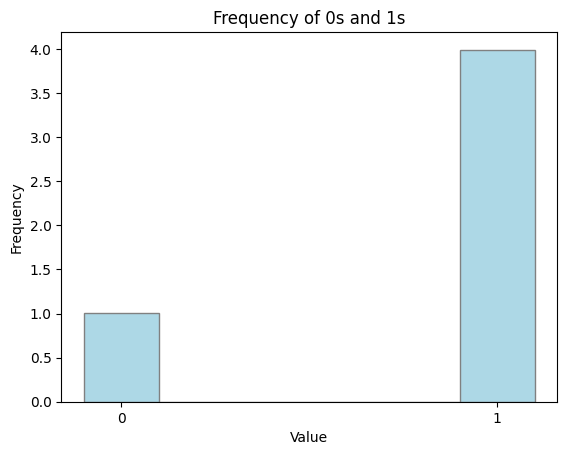

In [133]:

history= np.loadtxt("receptor_occupancy.txt")
flat_matrix = np.concatenate(history).ravel().astype(int)

# Plot histogram
%matplotlib inline
plt.hist(flat_matrix,bins=[-0.1, 0.1, 0.9, 1.1] ,edgecolor='gray', color= "lightblue",density=True)
plt.xticks([0, 1])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of 0s and 1s')
plt.show()

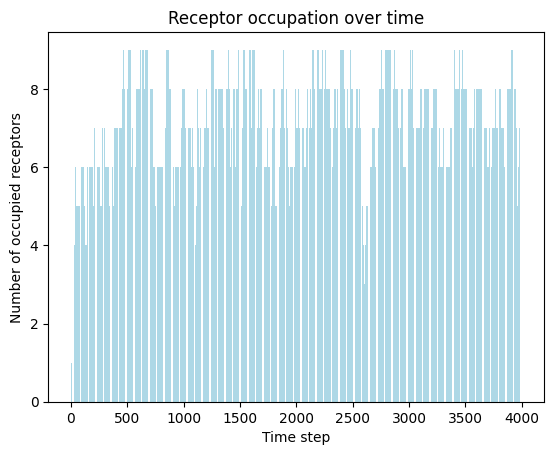

In [134]:
receptor_occupied = np.sum(history, axis=1)
plt.bar(range(len(receptor_occupied)), receptor_occupied, color= "lightblue")
plt.xlabel('Time step')
plt.ylabel('Number of occupied receptors')
plt.title('Receptor occupation over time')
plt.show()
